**Importing Libraries**

In [1]:
import gym
import numpy as np
import math
from collections import deque
import time
import matplotlib
import matplotlib.pyplot as plt

**Exploring the Environment**

In [2]:
envi = gym.make('MountainCar-v0')
envi.reset()

print('State space: ', envi.observation_space)
print('Action space:', envi.action_space)

State space:  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space: Discrete(3)


In [3]:
print(envi.observation_space.low)
print(envi.observation_space.high)

[-1.2  -0.07]
[0.6  0.07]


In [4]:
class MountaincarQAgent():
    def __init__(self, buckets=(12, 12), num_episodes=500000, min_epsilon=0.01, discount=0.99, decay=100, force=True):
        self.buckets = buckets
        self.num_episodes = num_episodes
        self.min_epsilon = min_epsilon
        self.discount = discount
        self.decay = decay

        self.env = gym.make('MountainCar-v0')
        self.upper_bounds = [self.env.observation_space.high[0], self.env.observation_space.high[1]]
        self.lower_bounds = [self.env.observation_space.low[0], self.env.observation_space.low[1]]


        #print("ub : ",self.upper_bounds)
        #print("lb : ",self.lower_bounds)
        
        ## Concatination of tuples to get shape (12,12,3) for buckets=(12, 12)
        self.Q_table = np.zeros(self.buckets + (self.env.action_space.n,))        
        
        self.learning_rate = 0.008
        
        self.threshold = self.env.spec.reward_threshold
        print('threshold: ', self.threshold)

    def discretize_state(self, obs):
       # obs - it is the list of observations
        discretized = list()   
        for i in range(len(obs)): 
            # print("obs : ",obs) #len(obs) = 2 => obs :  [-0.5343753   0.00108897]
            #ub :  [0.6, 0.07]
            #lb :  [-1.2, -0.07]
            scaling = (obs[i] + abs(self.lower_bounds[i])) / (self.upper_bounds[i] - self.lower_bounds[i])
            # scaling = (-0.53 + (-1.2)) / (0.6 - (-1.2))
            new_obs = int(round((self.buckets[i] - 1) * scaling))
            new_obs = min(self.buckets[i] - 1, max(0, new_obs))
            #print(new_obs)
            discretized.append(new_obs)
        return tuple(discretized)

    
    def choose_action(self, state):
        if (np.random.random() < self.epsilon):
            return self.env.action_space.sample() 
        else:
            return np.argmax(self.Q_table[state])

    def update_q(self, state, action, reward, new_state):
        self.Q_table[state][action] += \
           self.learning_rate * (reward + self.discount * np.max(self.Q_table[new_state]) - self.Q_table[state][action])

    def get_epsilon(self, t):
       #print(1. - math.log10((t + 1) / self.decay))
      return max(self.min_epsilon, min(1., 1. - math.log10((t + 1) / self.decay)))

    
    def train(self):
        scores_deque = deque(maxlen=100)
        scores_array = []
        avg_scores_array = []  
        print_every = 50000
        time_start = time.time()
        iteration_graph=[]
        score_graph=[]
        for i_episode in range(self.num_episodes):
            current_state = self.discretize_state(self.env.reset())

            self.epsilon = self.get_epsilon(i_episode)
            #print("eps : ",self.epsilon)
            done = False
            
            episode_reward = 0
            time_step = 0
            
            while not done:
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                #env. step() : This command will take an action at each step. 
                #The action is specified as its parameter. Env. step function returns four parameters, namely observation, reward, done and info.   
                new_state = self.discretize_state(obs)
                self.update_q(current_state, action, reward, new_state)
                current_state = new_state
                time_step += 1
                episode_reward += reward
                
            scores_deque.append(episode_reward)
            scores_array.append(episode_reward)
            
            avg_score = np.mean(scores_deque)
            avg_scores_array.append(avg_score)
            s = (int)(time.time() - time_start)
            
            if i_episode % print_every == 0 and i_episode > 0:
                iteration_graph.append(i_episode)
                score_graph.append(avg_score)
                print('Episode: {}, Timesteps:  {}, Score: {:5},  Avg.Score: {:.2f}, eps-greedy: {:5.2f}, Time: {:02}:{:02}:{:02}'.\
                    format(i_episode, time_step, episode_reward, avg_score, self.epsilon, s//3600, s%3600//60, s%60))    
                
            if avg_score >= self.threshold: 
                print('\n Environment solved in {:d} episodes!\tAverage Score: {:.2f}'. \
                    format(i_episode, np.mean(scores_deque)))
                break                                
        print(iteration_graph)
        print(score_graph)
        print('Finished training!')
        
        return scores_array, avg_scores_array,iteration_graph,score_graph

    def run(self):
        self.env = gym.wrappers.Monitor(self.env,'Mountaincar', force=True)
        t = 0
        done = False
        current_state = self.discretize_state(self.env.reset())
        while not done:
                self.env.render()
                t = t+1
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                current_state = new_state
            
        return t
    def close(self):
        self.env.close()

threshold:  -110.0
Episode: 50000, Timesteps:  162, Score: -162.0,  Avg.Score: -143.33, eps-greedy:  0.01, Time: 00:12:42
Episode: 100000, Timesteps:  135, Score: -135.0,  Avg.Score: -132.52, eps-greedy:  0.01, Time: 00:24:09
Episode: 150000, Timesteps:  165, Score: -165.0,  Avg.Score: -144.30, eps-greedy:  0.01, Time: 00:34:21
Episode: 200000, Timesteps:  158, Score: -158.0,  Avg.Score: -148.45, eps-greedy:  0.01, Time: 00:44:53
Episode: 250000, Timesteps:  142, Score: -142.0,  Avg.Score: -140.59, eps-greedy:  0.01, Time: 00:54:06
Episode: 300000, Timesteps:  135, Score: -135.0,  Avg.Score: -165.67, eps-greedy:  0.01, Time: 01:03:38
Episode: 350000, Timesteps:  159, Score: -159.0,  Avg.Score: -152.34, eps-greedy:  0.01, Time: 08:22:37
Episode: 400000, Timesteps:  149, Score: -149.0,  Avg.Score: -161.14, eps-greedy:  0.01, Time: 08:34:34
Episode: 450000, Timesteps:  108, Score: -108.0,  Avg.Score: -143.08, eps-greedy:  0.01, Time: 08:46:57
[50000, 100000, 150000, 200000, 250000, 300000

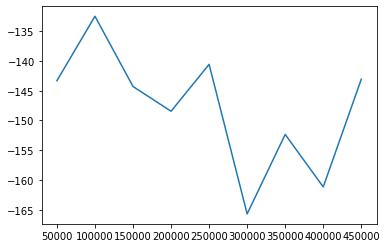

In [5]:
agent = MountaincarQAgent()
scores, avg_scores,i_graph_original,s_graph_original = agent.train()
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots() # Create a figure containing a single axes.
ax.plot(i_graph_original, s_graph_original)  # Plot some data on the axes.

**Hyper Parameter Tuning - Learning rate**


**From 0.008 -> 0.05**

In [6]:
class MountaincarQAgent_hp1():
    def __init__(self, buckets=(12, 12), num_episodes=500000, min_epsilon=0.01, discount=0.99, decay=100, force=True):
        self.buckets = buckets
        self.num_episodes = num_episodes
        self.min_epsilon = min_epsilon
        self.discount = discount
        self.decay = decay

        self.env = gym.make('MountainCar-v0')
        self.upper_bounds = [self.env.observation_space.high[0], self.env.observation_space.high[1]]
        self.lower_bounds = [self.env.observation_space.low[0], self.env.observation_space.low[1]]

        #print("ub : ",self.upper_bounds)
        #print("lb : ",self.lower_bounds)
        
        ## Concatination of tuples to get shape (12,12,3) for buckets=(12, 12)
        self.Q_table = np.zeros(self.buckets + (self.env.action_space.n,))        
        
        self.learning_rate = 0.05
        
        self.threshold = self.env.spec.reward_threshold
        print('threshold: ', self.threshold)

    def discretize_state(self, obs):
       # obs - it is the list of observations
        discretized = list()
        for i in range(len(obs)):
            # print("obs : ",obs) #len(obs) = 2 => obs :  [-0.5343753   0.00108897]
            #ub :  [0.6, 0.07]
            #lb :  [-1.2, -0.07]
            scaling = (obs[i] + abs(self.lower_bounds[i])) / (self.upper_bounds[i] - self.lower_bounds[i])
            # scaling = (-0.53 + (-1.2)) / (0.6 - (-1.2))
            new_obs = int(round((self.buckets[i] - 1) * scaling))
            new_obs = min(self.buckets[i] - 1, max(0, new_obs))
            #print(new_obs)
            discretized.append(new_obs)
        return tuple(discretized)

    
    def choose_action(self, state):
        if (np.random.random() < self.epsilon):
            return self.env.action_space.sample() 
        else:
            return np.argmax(self.Q_table[state])

    def update_q(self, state, action, reward, new_state):
        self.Q_table[state][action] += \
           self.learning_rate * (reward + self.discount * np.max(self.Q_table[new_state]) - self.Q_table[state][action])

    def get_epsilon(self, t):
      #print(1. - math.log10((t + 1) / self.decay))
      return max(self.min_epsilon, min(1., 1. - math.log10((t + 1) / self.decay)))

    
    def train(self):
        scores_deque = deque(maxlen=100)
        scores_array = []
        avg_scores_array = []  
        print_every = 50000
        time_start = time.time()
        iteration_graph_L=[]
        score_graph_L=[]
        for i_episode in range(self.num_episodes):
            current_state = self.discretize_state(self.env.reset())

            self.epsilon = self.get_epsilon(i_episode)
            #print("eps : ",self.epsilon)
            done = False
            
            episode_reward = 0
            time_step = 0
            
            while not done:
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                #env. step() : This command will take an action at each step. 
                #The action is specified as its parameter. Env. step function returns four parameters, namely observation, reward, done and info.   
                new_state = self.discretize_state(obs)
                self.update_q(current_state, action, reward, new_state)
                current_state = new_state
                time_step += 1
                episode_reward += reward
                
            scores_deque.append(episode_reward)
            scores_array.append(episode_reward)
            
            avg_score = np.mean(scores_deque)
            avg_scores_array.append(avg_score)
            
            s = (int)(time.time() - time_start)
            
            if i_episode % print_every == 0 and i_episode > 0:
                iteration_graph_L.append(i_episode)
                score_graph_L.append(avg_score)
                print('Episode: {}, Timesteps:  {}, Score: {:5},  Avg.Score: {:.2f}, eps-greedy: {:5.2f}, Time: {:02}:{:02}:{:02}'.\
                    format(i_episode, time_step, episode_reward, avg_score, self.epsilon, s//3600, s%3600//60, s%60))    
                
            if avg_score >= self.threshold: 
                print('\n Environment solved in {:d} episodes!\tAverage Score: {:.2f}'. \
                    format(i_episode, np.mean(scores_deque)))
                break                                

        print('Finished training!')
        
        return scores_array, avg_scores_array,iteration_graph_L,score_graph_L

    def run(self):
        self.env = gym.wrappers.Monitor(self.env,'Mountaincar', force=True)
        t = 0
        done = False
        current_state = self.discretize_state(self.env.reset())
        while not done:
                self.env.render()
                t = t+1
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                current_state = new_state
            
        return t
    def close(self):
        self.env.close()

agent = MountaincarQAgent_hp1()
scores, avg_scores,iteration_graph_L,score_graph_L = agent.train()  
print(iteration_graph_L)
print(score_graph_L)

threshold:  -110.0
Episode: 50000, Timesteps:  149, Score: -149.0,  Avg.Score: -148.03, eps-greedy:  0.01, Time: 00:14:39
Episode: 100000, Timesteps:  148, Score: -148.0,  Avg.Score: -149.75, eps-greedy:  0.01, Time: 00:26:32
Episode: 150000, Timesteps:  123, Score: -123.0,  Avg.Score: -162.18, eps-greedy:  0.01, Time: 00:38:16
Episode: 200000, Timesteps:  145, Score: -145.0,  Avg.Score: -170.07, eps-greedy:  0.01, Time: 00:50:15
Episode: 250000, Timesteps:  137, Score: -137.0,  Avg.Score: -137.01, eps-greedy:  0.01, Time: 01:01:50
Episode: 300000, Timesteps:  149, Score: -149.0,  Avg.Score: -153.83, eps-greedy:  0.01, Time: 01:14:10
Episode: 350000, Timesteps:  174, Score: -174.0,  Avg.Score: -191.68, eps-greedy:  0.01, Time: 01:26:47
Episode: 400000, Timesteps:  136, Score: -136.0,  Avg.Score: -142.69, eps-greedy:  0.01, Time: 01:41:22
Episode: 450000, Timesteps:  164, Score: -164.0,  Avg.Score: -147.37, eps-greedy:  0.01, Time: 01:59:16
Finished training!
[50000, 100000, 150000, 200

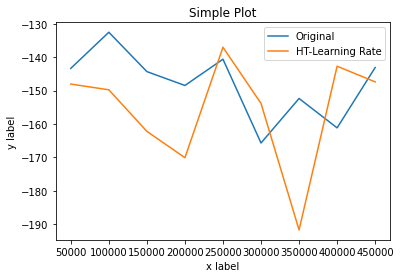

In [7]:
x = iteration_graph_L

# Note that even in the OO-style, we use `.pyplot.figure` to create the figure.
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(x, s_graph_original, label='Original')  # Plot some data on the axes.
ax.plot(x, score_graph_L, label='HT-Learning Rate')  # Plot more data on the axes...

ax.set_xlabel('x label')  # Add an x-label to the axes.
ax.set_ylabel('y label')  # Add a y-label to the axes.
ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend()  # Add a legend.

**Hyper Parameter Tuning - Discount rate**


**From 0.99 -> 0.55**

In [10]:
class MountaincarQAgent_hp2():
    def __init__(self, buckets=(12, 12), num_episodes=500000, min_epsilon=0.01, discount=0.55, decay=100, force=True):
        self.buckets = buckets
        self.num_episodes = num_episodes
        self.min_epsilon = min_epsilon
        self.discount = discount
        self.decay = decay

        self.env = gym.make('MountainCar-v0')
        self.upper_bounds = [self.env.observation_space.high[0], self.env.observation_space.high[1]]
        self.lower_bounds = [self.env.observation_space.low[0], self.env.observation_space.low[1]]


        #print("ub : ",self.upper_bounds)
        #print("lb : ",self.lower_bounds)
        
        ## Concatination of tuples to get shape (12,12,3) for buckets=(12, 12)
        self.Q_table = np.zeros(self.buckets + (self.env.action_space.n,))        
        
        self.learning_rate = 0.008
        
        self.threshold = self.env.spec.reward_threshold
        print('threshold: ', self.threshold)

    def discretize_state(self, obs):
       # obs - it is the list of observations
        discretized = list()   
        for i in range(len(obs)): 
            # print("obs : ",obs) #len(obs) = 2 => obs :  [-0.5343753   0.00108897]
            #ub :  [0.6, 0.07]
            #lb :  [-1.2, -0.07]
            scaling = (obs[i] + abs(self.lower_bounds[i])) / (self.upper_bounds[i] - self.lower_bounds[i])
            # scaling = (-0.53 + (-1.2)) / (0.6 - (-1.2))
            new_obs = int(round((self.buckets[i] - 1) * scaling))
            new_obs = min(self.buckets[i] - 1, max(0, new_obs))
            #print(new_obs)
            discretized.append(new_obs)
        return tuple(discretized)

    
    def choose_action(self, state):
        if (np.random.random() < self.epsilon):
            return self.env.action_space.sample() 
        else:
            return np.argmax(self.Q_table[state])

    def update_q(self, state, action, reward, new_state):
        self.Q_table[state][action] += \
           self.learning_rate * (reward + self.discount * np.max(self.Q_table[new_state]) - self.Q_table[state][action])

    def get_epsilon(self, t):
      #print(1. - math.log10((t + 1) / self.decay))
      return max(self.min_epsilon, min(1., 1. - math.log10((t + 1) / self.decay)))

    
    def train(self):
        scores_deque = deque(maxlen=100)
        scores_array = []
        avg_scores_array = []  
        print_every = 50000
        time_start = time.time()
        iteration_graph_Disc=[]
        score_graph_Disc=[]
        for i_episode in range(self.num_episodes):
            current_state = self.discretize_state(self.env.reset())

            self.epsilon = self.get_epsilon(i_episode)
            #print("eps : ",self.epsilon)
            done = False
            
            episode_reward = 0
            time_step = 0
            
            while not done:
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                #env. step() : This command will take an action at each step. 
                #The action is specified as its parameter. Env. step function returns four parameters, namely observation, reward, done and info.   
                new_state = self.discretize_state(obs)
                self.update_q(current_state, action, reward, new_state)
                current_state = new_state
                time_step += 1
                episode_reward += reward
                
            scores_deque.append(episode_reward)
            scores_array.append(episode_reward)
            
            avg_score = np.mean(scores_deque)
            avg_scores_array.append(avg_score)
            
            s = (int)(time.time() - time_start)
            
            if i_episode % print_every == 0 and i_episode > 0:
                iteration_graph_Disc.append(i_episode)
                score_graph_Disc.append(avg_score)
                print('Episode: {}, Timesteps:  {}, Score: {:5},  Avg.Score: {:.2f}, eps-greedy: {:5.2f}, Time: {:02}:{:02}:{:02}'.\
                    format(i_episode, time_step, episode_reward, avg_score, self.epsilon, s//3600, s%3600//60, s%60))    
                
            if avg_score >= self.threshold: 
                print('\n Environment solved in {:d} episodes!\tAverage Score: {:.2f}'. \
                    format(i_episode, np.mean(scores_deque)))
                break                                

        print('Finished training!')
        
        return scores_array, avg_scores_array,iteration_graph_Disc,score_graph_Disc

    def run(self):
        self.env = gym.wrappers.Monitor(self.env,'Mountaincar', force=True)
        t = 0
        done = False
        current_state = self.discretize_state(self.env.reset())
        while not done:
                self.env.render()
                t = t+1
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                current_state = new_state
            
        return t
    def close(self):
        self.env.close()

agent = MountaincarQAgent_hp2()
scores, avg_scores,iteration_graph_Disc,score_graph_Disc = agent.train()  

threshold:  -110.0
Episode: 50000, Timesteps:  155, Score: -155.0,  Avg.Score: -163.71, eps-greedy:  0.01, Time: 00:17:22
Episode: 100000, Timesteps:  140, Score: -140.0,  Avg.Score: -142.95, eps-greedy:  0.01, Time: 00:35:16
Episode: 150000, Timesteps:  118, Score: -118.0,  Avg.Score: -144.91, eps-greedy:  0.01, Time: 00:47:53
Episode: 200000, Timesteps:  186, Score: -186.0,  Avg.Score: -156.67, eps-greedy:  0.01, Time: 00:59:19
Episode: 250000, Timesteps:  139, Score: -139.0,  Avg.Score: -144.71, eps-greedy:  0.01, Time: 01:13:55
Episode: 300000, Timesteps:  179, Score: -179.0,  Avg.Score: -178.51, eps-greedy:  0.01, Time: 01:27:04
Episode: 350000, Timesteps:  185, Score: -185.0,  Avg.Score: -157.22, eps-greedy:  0.01, Time: 01:40:45
Episode: 400000, Timesteps:  184, Score: -184.0,  Avg.Score: -189.14, eps-greedy:  0.01, Time: 01:53:18
Episode: 450000, Timesteps:  200, Score: -200.0,  Avg.Score: -195.30, eps-greedy:  0.01, Time: 02:05:23
Finished training!


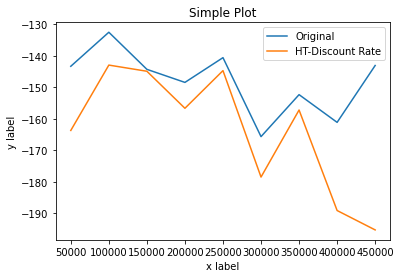

In [11]:
x = iteration_graph_Disc

# Note that even in the OO-style, we use `.pyplot.figure` to create the figure.
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(x, s_graph_original, label='Original')  # Plot some data on the axes.
ax.plot(x, score_graph_Disc, label='HT-Discount Rate')  # Plot more data on the axes...

ax.set_xlabel('x label')  # Add an x-label to the axes.
ax.set_ylabel('y label')  # Add a y-label to the axes.
ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend()  # Add a legend.

**Hyper Parameter Tuning - Decay**


**From 100 -> 10**

In [12]:
class MountaincarQAgent_hp3():
    def __init__(self, buckets=(12, 12), num_episodes=500000, min_epsilon=0.01, discount=0.99, decay=10, force=True):
        self.buckets = buckets
        self.num_episodes = num_episodes
        self.min_epsilon = min_epsilon
        self.discount = discount
        self.decay = decay

        self.env = gym.make('MountainCar-v0')
        self.upper_bounds = [self.env.observation_space.high[0], self.env.observation_space.high[1]]
        self.lower_bounds = [self.env.observation_space.low[0], self.env.observation_space.low[1]]


        #print("ub : ",self.upper_bounds)
        #print("lb : ",self.lower_bounds)
        
        ## Concatination of tuples to get shape (12,12,3) for buckets=(12, 12)
        
        self.Q_table = np.zeros(self.buckets + (self.env.action_space.n,))        
        
        self.learning_rate = 0.008
        
        self.threshold = self.env.spec.reward_threshold
        print('threshold: ', self.threshold)

    def discretize_state(self, obs):
       # obs - it is the list of observations
        discretized = list()   
        for i in range(len(obs)): 
            # print("obs : ",obs) #len(obs) = 2 => obs :  [-0.5343753   0.00108897]
            #ub :  [0.6, 0.07]
            #lb :  [-1.2, -0.07]
            scaling = (obs[i] + abs(self.lower_bounds[i])) / (self.upper_bounds[i] - self.lower_bounds[i])
            # scaling = (-0.53 + (-1.2)) / (0.6 - (-1.2))
            new_obs = int(round((self.buckets[i] - 1) * scaling))
            new_obs = min(self.buckets[i] - 1, max(0, new_obs))
            #print(new_obs)
            discretized.append(new_obs)
        return tuple(discretized)

    
    def choose_action(self, state):
        if (np.random.random() < self.epsilon):
            return self.env.action_space.sample() 
        else:
            return np.argmax(self.Q_table[state])

    def update_q(self, state, action, reward, new_state):
        self.Q_table[state][action] += \
           self.learning_rate * (reward + self.discount * np.max(self.Q_table[new_state]) - self.Q_table[state][action])

    def get_epsilon(self, t):
      #print(1. - math.log10((t + 1) / self.decay))
      return max(self.min_epsilon, min(1., 1. - math.log10((t + 1) / self.decay)))

    
    def train(self):
        scores_deque = deque(maxlen=100)
        scores_array = []
        avg_scores_array = []  
        print_every = 50000
        time_start = time.time()
        iteration_graph_Decay=[]
        score_graph_Decay=[]
        for i_episode in range(self.num_episodes):
            current_state = self.discretize_state(self.env.reset())

            self.epsilon = self.get_epsilon(i_episode)
            #print("eps : ",self.epsilon)
            done = False
            
            episode_reward = 0
            time_step = 0
            
            while not done:
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                #env. step() : This command will take an action at each step. 
                #The action is specified as its parameter. Env. step function returns four parameters, namely observation, reward, done and info.   
                new_state = self.discretize_state(obs)
                self.update_q(current_state, action, reward, new_state)
                current_state = new_state
                time_step += 1
                episode_reward += reward
                
            scores_deque.append(episode_reward)
            scores_array.append(episode_reward)
            
            avg_score = np.mean(scores_deque)
            avg_scores_array.append(avg_score)
            
            s = (int)(time.time() - time_start)
            
            if i_episode % print_every == 0 and i_episode > 0:
                iteration_graph_Decay.append(i_episode)
                score_graph_Decay.append(avg_score)
                print('Episode: {}, Timesteps:  {}, Score: {:5},  Avg.Score: {:.2f}, eps-greedy: {:5.2f}, Time: {:02}:{:02}:{:02}'.\
                    format(i_episode, time_step, episode_reward, avg_score, self.epsilon, s//3600, s%3600//60, s%60))    
                
            if avg_score >= self.threshold: 
                print('\n Environment solved in {:d} episodes!\tAverage Score: {:.2f}'. \
                    format(i_episode, np.mean(scores_deque)))
                break                                

        print('Finished training!')
        
        return scores_array, avg_scores_array ,iteration_graph_Decay,score_graph_Decay

    def run(self):
        self.env = gym.wrappers.Monitor(self.env,'Mountaincar', force=True)
        t = 0
        done = False
        current_state = self.discretize_state(self.env.reset())
        while not done:
                self.env.render()
                t = t+1
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                current_state = new_state
            
        return t
    def close(self):
        self.env.close()

agent = MountaincarQAgent_hp3()
scores, avg_scores,iteration_graph_Decay,score_graph_Decay = agent.train()  

threshold:  -110.0
Episode: 50000, Timesteps:  200, Score: -200.0,  Avg.Score: -173.82, eps-greedy:  0.01, Time: 00:12:58
Episode: 100000, Timesteps:  160, Score: -160.0,  Avg.Score: -158.60, eps-greedy:  0.01, Time: 00:24:12
Episode: 150000, Timesteps:  154, Score: -154.0,  Avg.Score: -150.52, eps-greedy:  0.01, Time: 00:35:44
Episode: 200000, Timesteps:  157, Score: -157.0,  Avg.Score: -144.03, eps-greedy:  0.01, Time: 00:47:18
Episode: 250000, Timesteps:  161, Score: -161.0,  Avg.Score: -141.75, eps-greedy:  0.01, Time: 00:59:36
Episode: 300000, Timesteps:  182, Score: -182.0,  Avg.Score: -176.36, eps-greedy:  0.01, Time: 01:10:26
Episode: 350000, Timesteps:  162, Score: -162.0,  Avg.Score: -141.21, eps-greedy:  0.01, Time: 01:22:23
Episode: 400000, Timesteps:  152, Score: -152.0,  Avg.Score: -153.54, eps-greedy:  0.01, Time: 01:32:48
Episode: 450000, Timesteps:  109, Score: -109.0,  Avg.Score: -135.90, eps-greedy:  0.01, Time: 01:42:54
Finished training!


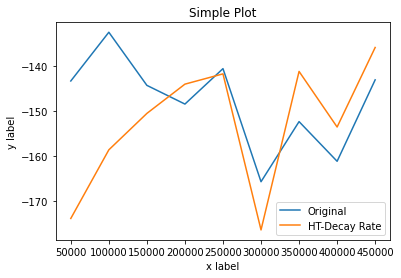

In [13]:
x = iteration_graph_Decay

# Note that even in the OO-style, we use `.pyplot.figure` to create the figure.
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(x, s_graph_original, label='Original')  # Plot some data on the axes.
ax.plot(x, score_graph_Decay, label='HT-Decay Rate')  # Plot more data on the axes...

ax.set_xlabel('x label')  # Add an x-label to the axes.
ax.set_ylabel('y label')  # Add a y-label to the axes.
ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend()  # Add a legend.

**Hyper Parameter Tuning - Epsilon**


**From 0.01 -> 0.1**

In [14]:
class MountaincarQAgent_hp4():
    def __init__(self, buckets=(12, 12), num_episodes=500000, min_epsilon=0.1, discount=0.99, decay=100, force=True):
        self.buckets = buckets
        self.num_episodes = num_episodes
        self.min_epsilon = min_epsilon
        self.discount = discount
        self.decay = decay

        self.env = gym.make('MountainCar-v0')
        self.upper_bounds = [self.env.observation_space.high[0], self.env.observation_space.high[1]]
        self.lower_bounds = [self.env.observation_space.low[0], self.env.observation_space.low[1]]


        #print("ub : ",self.upper_bounds)
        #print("lb : ",self.lower_bounds)
        
        ## Concatination of tuples to get shape (12,12,3) for buckets=(12, 12)
        self.Q_table = np.zeros(self.buckets + (self.env.action_space.n,))        
        
        self.learning_rate = 0.008
        
        self.threshold = self.env.spec.reward_threshold
        print('threshold: ', self.threshold)

    def discretize_state(self, obs):
       # obs - it is the list of observations
        discretized = list()   
        for i in range(len(obs)): 
            # print("obs : ",obs) #len(obs) = 2 => obs :  [-0.5343753   0.00108897]
            #ub :  [0.6, 0.07]
            #lb :  [-1.2, -0.07]
            scaling = (obs[i] + abs(self.lower_bounds[i])) / (self.upper_bounds[i] - self.lower_bounds[i])
            # scaling = (-0.53 + (-1.2)) / (0.6 - (-1.2))
            new_obs = int(round((self.buckets[i] - 1) * scaling))
            new_obs = min(self.buckets[i] - 1, max(0, new_obs))
            #print(new_obs)
            discretized.append(new_obs)
        return tuple(discretized)

    
    def choose_action(self, state):
        if (np.random.random() < self.epsilon):
            return self.env.action_space.sample() 
        else:
            return np.argmax(self.Q_table[state])

    def update_q(self, state, action, reward, new_state):
        self.Q_table[state][action] += \
           self.learning_rate * (reward + self.discount * np.max(self.Q_table[new_state]) - self.Q_table[state][action])

    def get_epsilon(self, t):
      #print(1. - math.log10((t + 1) / self.decay))
      return max(self.min_epsilon, min(1., 1. - math.log10((t + 1) / self.decay)))

    
    def train(self):
        scores_deque = deque(maxlen=100)
        scores_array = []
        avg_scores_array = []  
        print_every = 50000
        time_start = time.time()
        i_graph_E=[]
        s_graph_E=[]
        for i_episode in range(self.num_episodes):
            current_state = self.discretize_state(self.env.reset())

            self.epsilon = self.get_epsilon(i_episode)
            #print("eps : ",self.epsilon)
            done = False
            
            episode_reward = 0
            time_step = 0
            
            while not done:
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                #env. step() : This command will take an action at each step. 
                #The action is specified as its parameter. Env. step function returns four parameters, namely observation, reward, done and info.   
                new_state = self.discretize_state(obs)
                self.update_q(current_state, action, reward, new_state)
                current_state = new_state
                time_step += 1
                episode_reward += reward
                
            scores_deque.append(episode_reward)
            scores_array.append(episode_reward)
            
            avg_score = np.mean(scores_deque)
            avg_scores_array.append(avg_score)
            
            s = (int)(time.time() - time_start)
            
            if i_episode % print_every == 0 and i_episode > 0: 
                i_graph_E.append(i_episode)
                s_graph_E.append(avg_score)
                print('Episode: {}, Timesteps:  {}, Score: {:5},  Avg.Score: {:.2f}, eps-greedy: {:5.2f}, Time: {:02}:{:02}:{:02}'.\
                    format(i_episode, time_step, episode_reward, avg_score, self.epsilon, s//3600, s%3600//60, s%60))    
                
            if avg_score >= self.threshold: 
                print('\n Environment solved in {:d} episodes!\tAverage Score: {:.2f}'. \
                    format(i_episode, np.mean(scores_deque)))
                break                                

        print('Finished training!')
        
        return scores_array, avg_scores_array,i_graph_E,s_graph_E

    def run(self):
        self.env = gym.wrappers.Monitor(self.env,'Mountaincar', force=True)
        t = 0
        done = False
        current_state = self.discretize_state(self.env.reset())
        while not done:
                self.env.render()
                t = t+1
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                current_state = new_state
            
        return t
    def close(self):
        self.env.close()


agent = MountaincarQAgent_hp4()
scores, avg_scores,iter_score_E,score_graph_E = agent.train() 

threshold:  -110.0
Episode: 50000, Timesteps:  185, Score: -185.0,  Avg.Score: -161.27, eps-greedy:  0.10, Time: 01:16:15
Episode: 100000, Timesteps:  200, Score: -200.0,  Avg.Score: -165.87, eps-greedy:  0.10, Time: 01:31:22
Episode: 150000, Timesteps:  177, Score: -177.0,  Avg.Score: -163.99, eps-greedy:  0.10, Time: 01:43:27
Episode: 200000, Timesteps:  152, Score: -152.0,  Avg.Score: -153.19, eps-greedy:  0.10, Time: 01:55:30
Episode: 250000, Timesteps:  110, Score: -110.0,  Avg.Score: -152.49, eps-greedy:  0.10, Time: 02:07:47
Episode: 300000, Timesteps:  151, Score: -151.0,  Avg.Score: -160.36, eps-greedy:  0.10, Time: 02:23:46
Episode: 350000, Timesteps:  120, Score: -120.0,  Avg.Score: -157.65, eps-greedy:  0.10, Time: 02:37:24
Episode: 400000, Timesteps:  153, Score: -153.0,  Avg.Score: -171.75, eps-greedy:  0.10, Time: 02:49:40
Episode: 450000, Timesteps:  164, Score: -164.0,  Avg.Score: -166.18, eps-greedy:  0.10, Time: 03:03:52
Finished training!


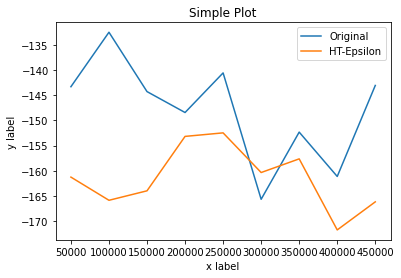

In [15]:
x = iter_score_E

# Note that even in the OO-style, we use `.pyplot.figure` to create the figure.
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(x, s_graph_original, label='Original')  # Plot some data on the axes.
ax.plot(x, score_graph_E, label='HT-Epsilon')  # Plot more data on the axes...

ax.set_xlabel('x label')  # Add an x-label to the axes.
ax.set_ylabel('y label')  # Add a y-label to the axes.
ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend()  # Add a legend.